In [13]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lightkurve as lk

starry.config.quiet = True
np.random.seed(1)

%matplotlib inline

In [14]:
import StarryStarryProcess as ssp

In [15]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

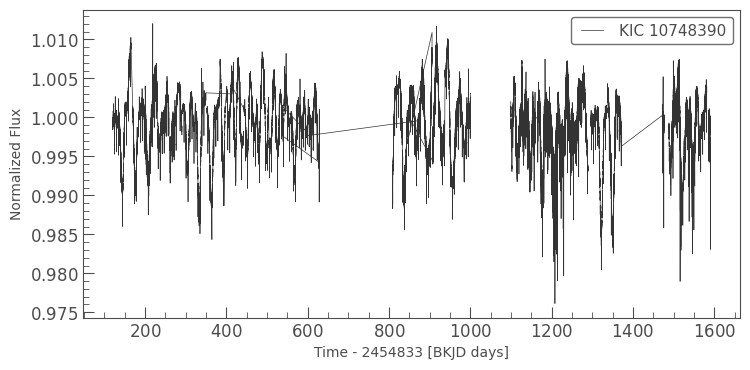

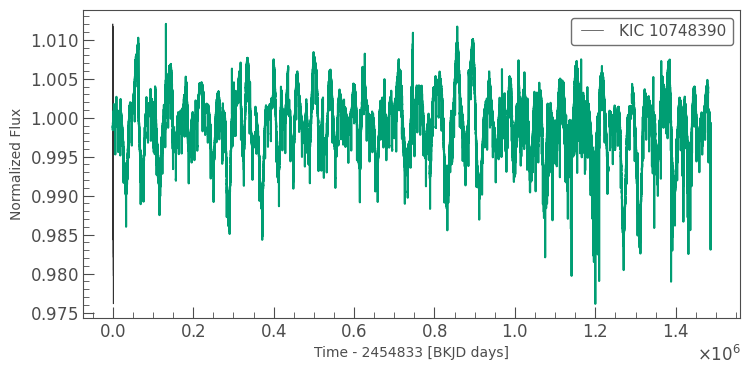

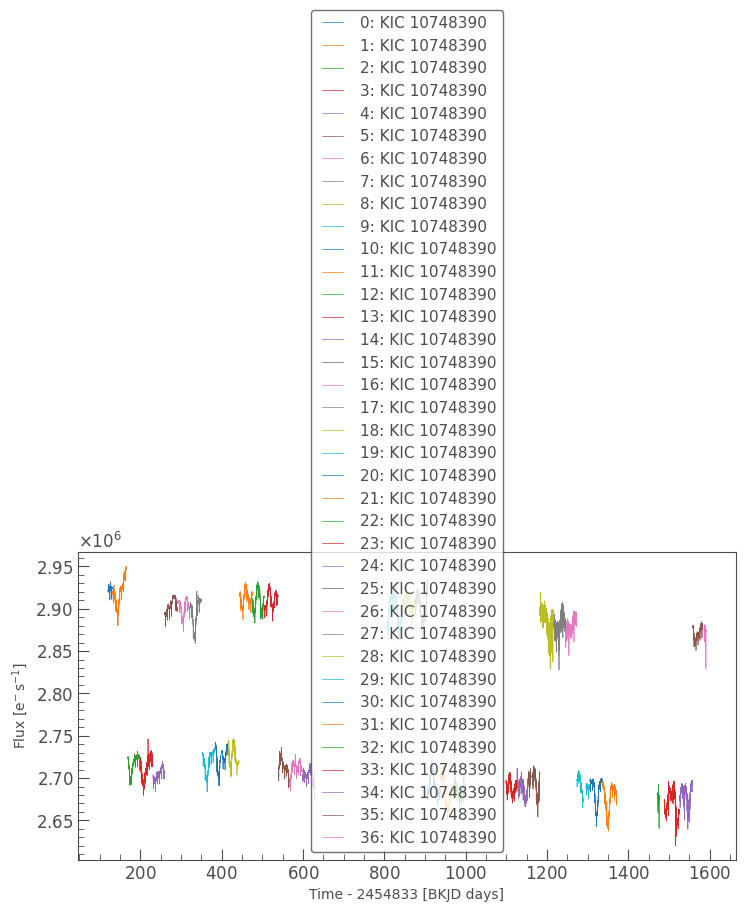

In [16]:
lc_collection.plot()

In [17]:
all_lc = lc_collection.stitch()

In [18]:
all_lc

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.52859840558085,9.9879408e-01,1.7174082e-04,0,3.223656e-04,555.58158,821.86413,5500,2.9128242e+06,2.3517690e+02,6.8893467e+03,2.1677258e+00,2.9205592e+06,5.0218484e+02,0,———,———,———,———,555.58158,6.6864952e-05,821.86413,1.9141044e-04,2.5442394e-04,-3.2165432e-03
120.5292795312198,9.9859810e-01,1.6646369e-04,10000000,3.223912e-04,555.58096,821.86687,5501,2.9122640e+06,2.3515198e+02,6.8895815e+03,2.1676188e+00,2.9199862e+06,4.8675406e+02,10000000,———,———,———,———,555.58096,6.6852146e-05,821.86687,1.9126690e-04,2.6533962e-04,-3.2072579e-03
120.52996075685951,9.9859607e-01,1.6158230e-04,10000000,3.224169e-04,555.58273,821.86533,5502,2.9122688e+06,2.3515186e+02,6.8898159e+03,2.1675119e+00,2.9199802e+06,4.7248047e+02,10000000,———,———,———,———,555.58273,6.6873072e-05,821.86533,1.9150550e-04,2.7625691e-04,-3.1979713e-03
120.53064188249846,9.9873668e-01,1.5708857e-04,0,3.224425e-04,555.58274,821.86521,5503,2.9126892e+06,2.3516835e+02,6.8900498e+03,2.1674051e+00,2.9203915e+06,4.5934039e+02,0,———,———,———,———,555.58274,6.6847140e-05,821.86521,1.9152994e-04,2.8717262e-04,-3.1886860e-03
120.53132310817455,9.9864805e-01,1.5296284e-04,0,3.224682e-04,555.58130,821.86659,5504,2.9124402e+06,2.3514540e+02,6.8902847e+03,2.1672983e+00,2.9201322e+06,4.4727640e+02,0,———,———,———,———,555.58130,6.6857276e-05,821.86659,1.9131499e-04,2.9808990e-04,-3.1793993e-03
120.5320042338135,9.9875557e-01,1.4920715e-04,0,3.224938e-04,555.58338,821.86437,5505,2.9127630e+06,2.3516986e+02,6.8905190e+03,2.1671915e+00,2.9204468e+06,4.3629446e+02,0,———,———,———,———,555.58338,6.6841698e-05,821.86437,1.9159318e-04,3.0900558e-04,-3.1701140e-03
120.53268535945244,9.9870324e-01,1.4579581e-04,0,3.225195e-04,555.58280,821.86600,5506,2.9126190e+06,2.3516171e+02,6.8907529e+03,2.1670847e+00,2.9202938e+06,4.2631943e+02,0,———,———,———,———,555.58280,6.6839348e-05,821.86600,1.9150582e-04,3.1992130e-04,-3.1608287e-03
120.53336638509063,9.9869567e-01,1.4272092e-04,0,3.225451e-04,555.58323,821.86398,5507,2.9126050e+06,2.3516237e+02,6.8909873e+03,2.1669776e+00,2.9202715e+06,4.1732819e+02,0,———,———,———,———,555.58323,6.6845379e-05,821.86398,1.9158299e-04,3.3083538e-04,-3.1515448e-03


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

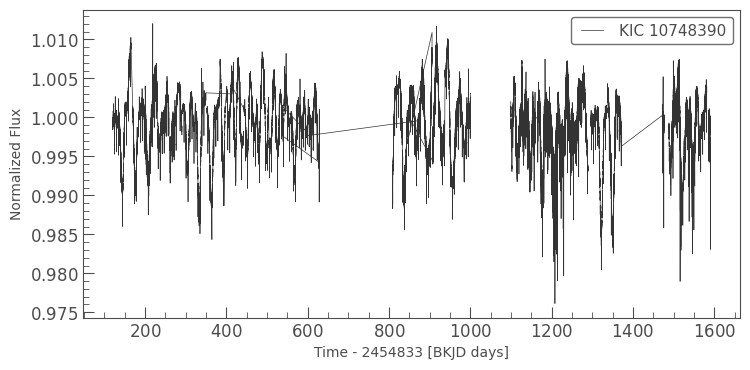

In [21]:
all_lc.plot()

In [22]:
all_lc=all_lc.remove_nans()

In [23]:
all_lc = all_lc[all_lc.quality==0]

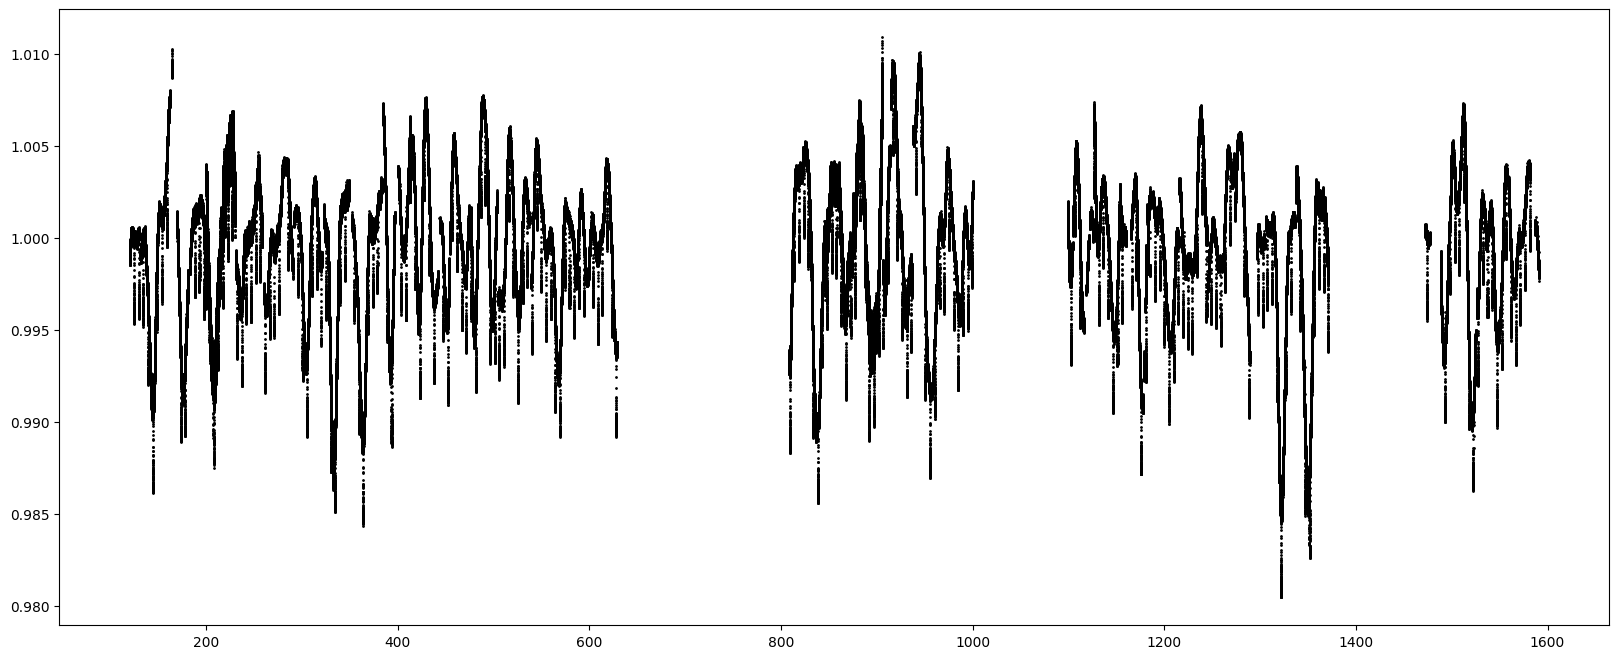

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value, all_lc.flux, "k.", ms=2)

(360.0, 380.0)

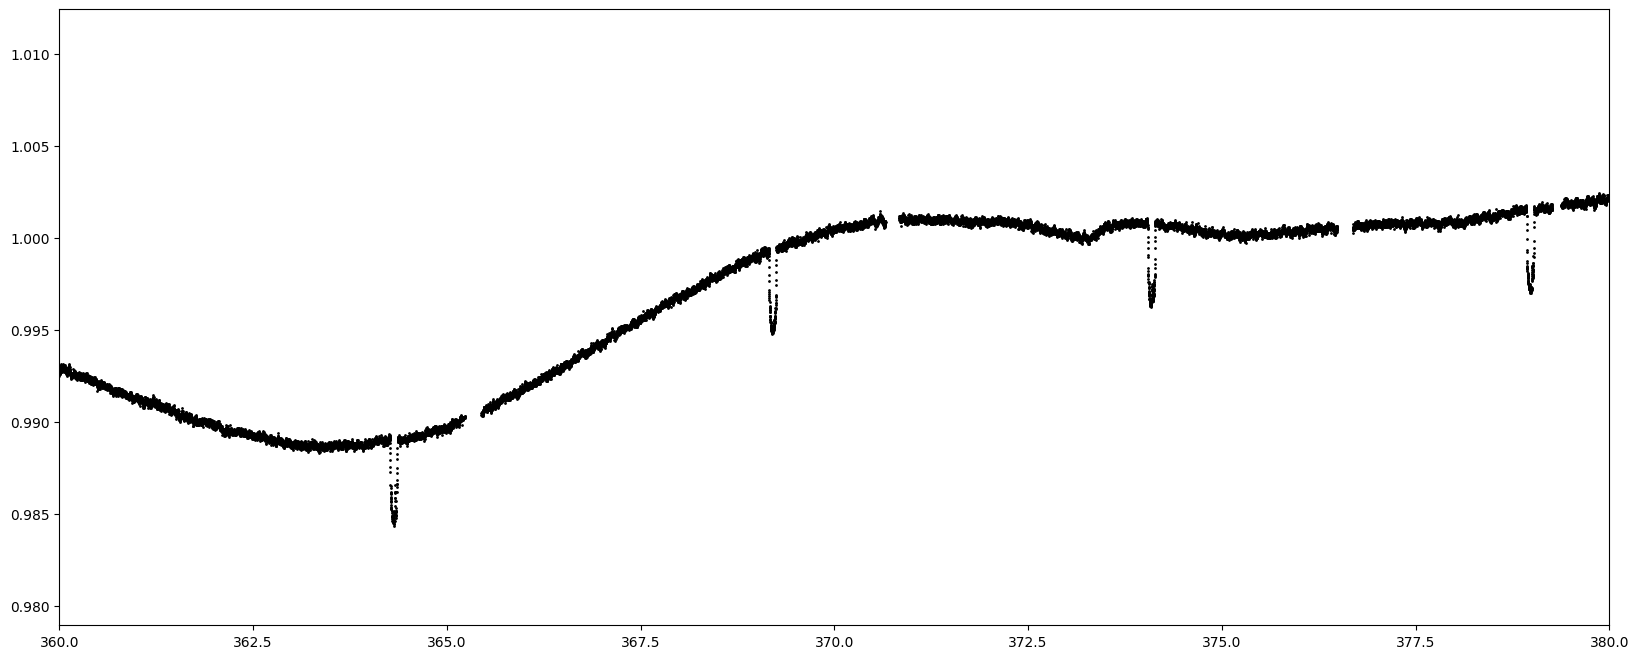

In [31]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value, all_lc.flux, "k.", ms=2)
plt.xlim(360,380)

<Figure size 2000x800 with 0 Axes>

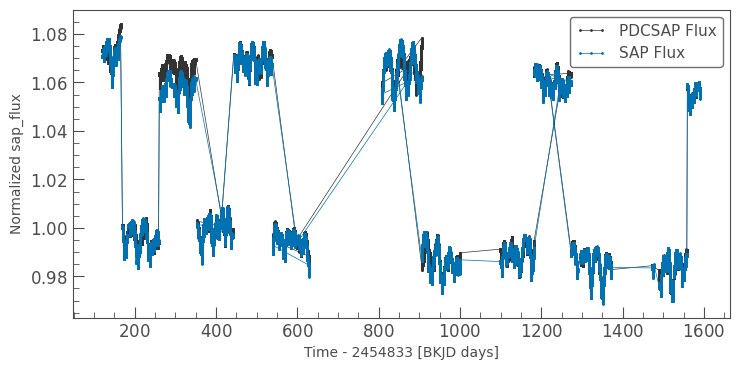

In [35]:
plt.figure(figsize=(20, 8))
ax = all_lc.plot(column='pdcsap_flux', label='PDCSAP Flux', normalize=True, marker='.')
all_lc.plot(column='sap_flux', label='SAP Flux', normalize=True, ax=ax, marker='.');

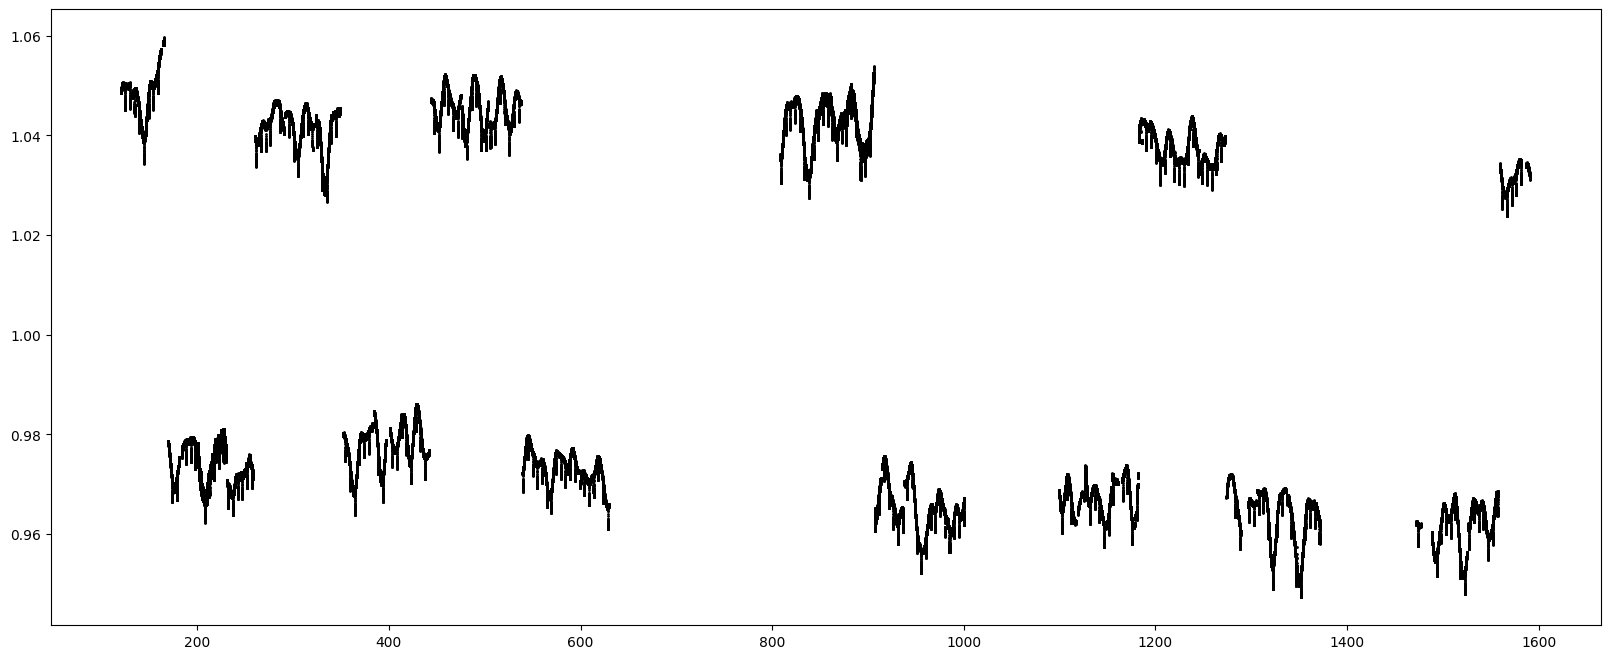

In [44]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value, all_lc.pdcsap_flux/np.mean(all_lc.pdcsap_flux), "k.", ms=2)

(360.0, 380.0)

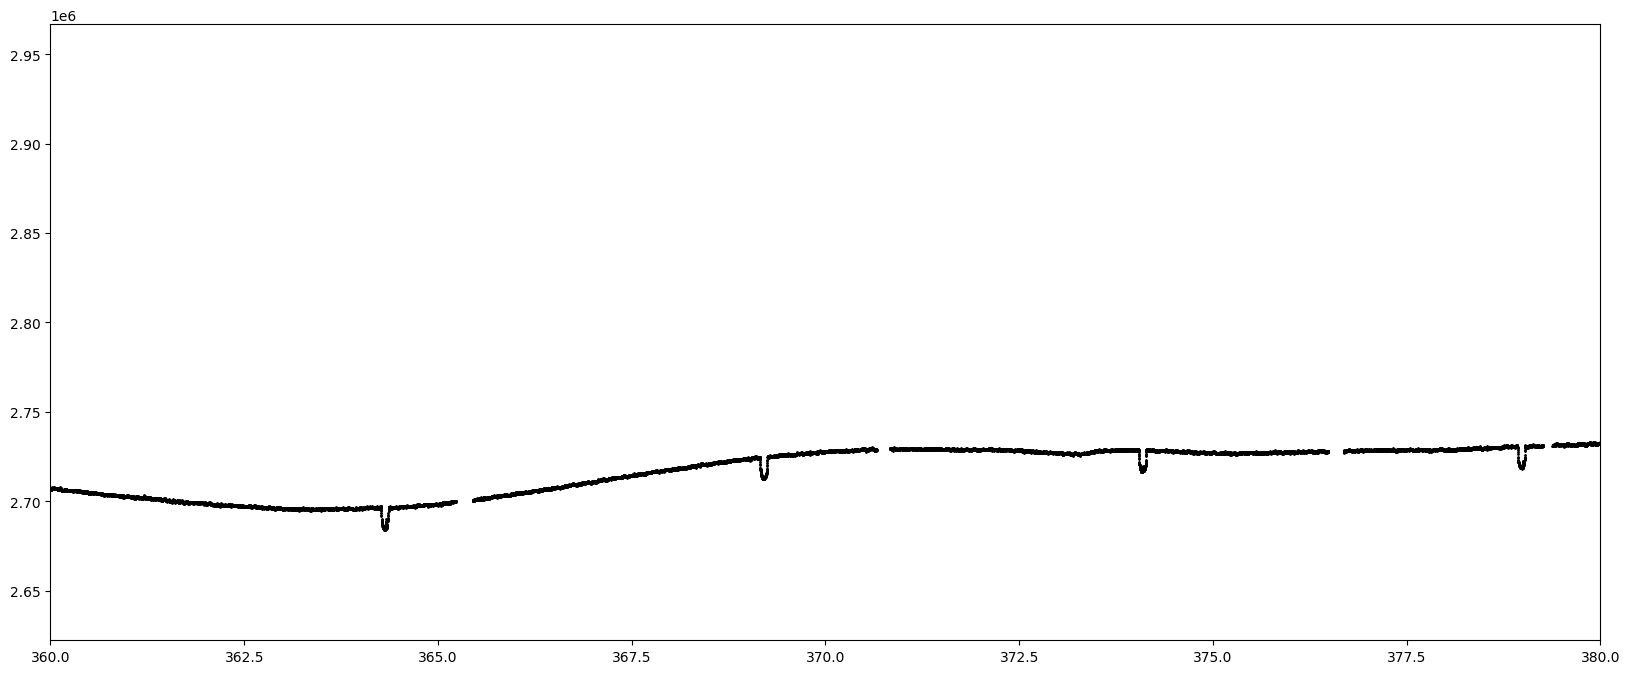

In [39]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value, all_lc.pdcsap_flux, "k.", ms=2)
plt.xlim(360,380)

(808.0, 907.0)

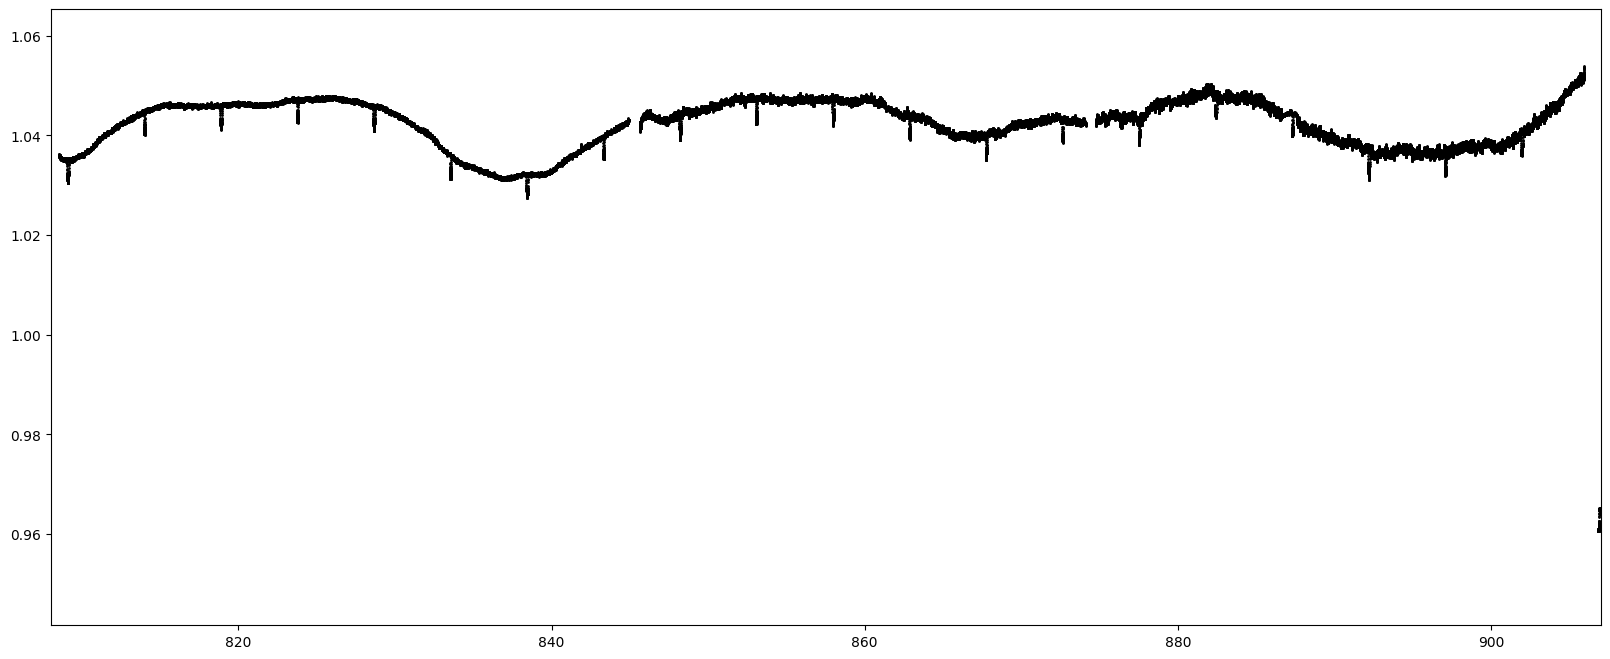

In [56]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value, all_lc.pdcsap_flux/np.mean(all_lc.pdcsap_flux), "k.", ms=2)
plt.xlim(808,907)

In [57]:
all_lc.time.value

array([ 120.52859841,  120.53064188,  120.53132311, ..., 1590.99103483,
       1591.0019331 , 1591.01010678])

In [81]:
time = all_lc.time.value[np.where((all_lc.time.value>=808) & (all_lc.time.value<=906))]

In [82]:
flux = all_lc.pdcsap_flux[np.where((all_lc.time.value>=808) & (all_lc.time.value<=906))]

In [83]:
time

array([874.77405217, 874.7747333 , 874.77541442, ..., 844.91673007,
       844.91809241, 844.91877354])

In [84]:
time.shape

(125732,)

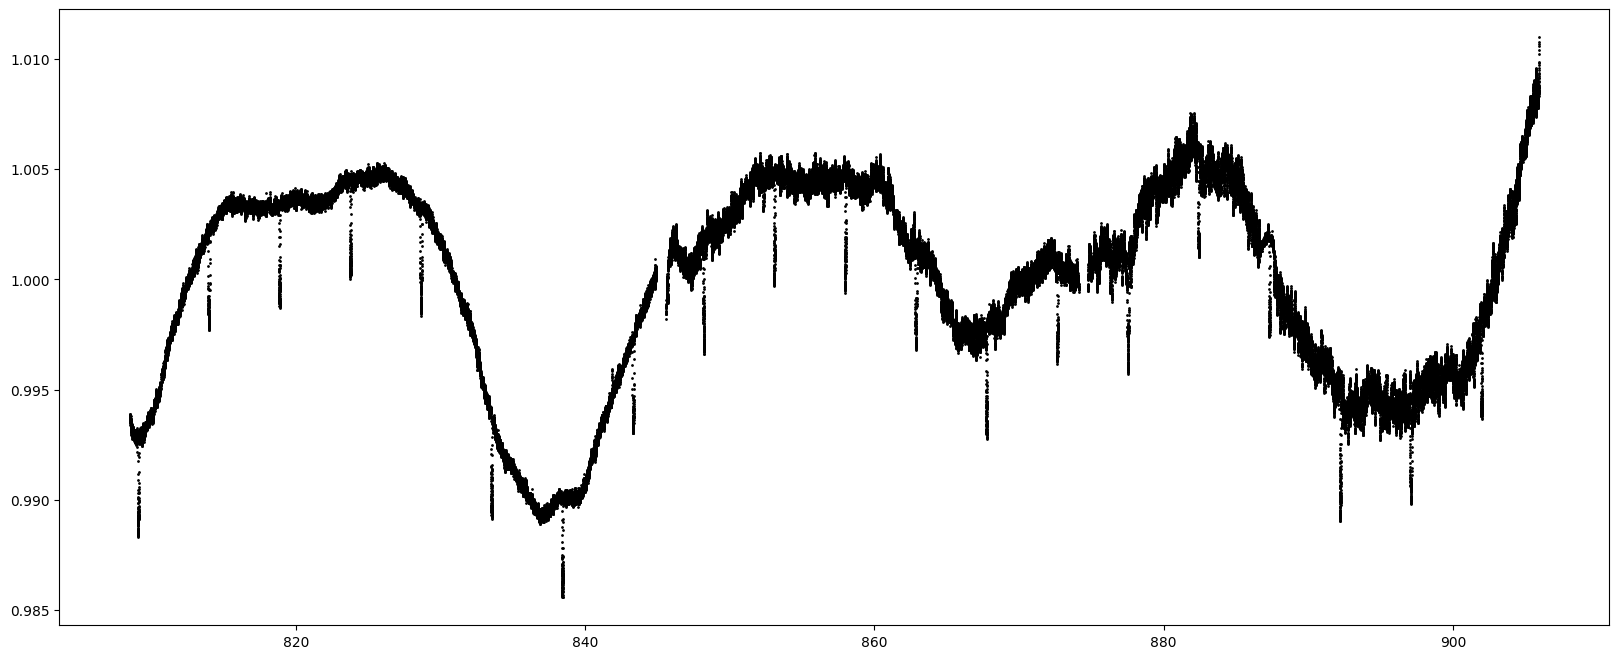

In [86]:
plt.figure(figsize=(20, 8))
plt.plot(time, flux/np.mean(flux), "k.", ms=2)